## Testing Clustering Methods


### Load the requirements

In [1]:
# Do not modify import block, all necessary imports are included
# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
%matplotlib inline

# This is for our hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

# For our k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn import datasets
import random

# for creating the x matrix to train
import sklearn
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom

import gsw
import math

In [2]:
ds = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_flt.nc')
ds1 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_avg_0001.nc')
dg = xr.open_dataset('/scratch/project_2000789/muramarg/waom10extend_grd.nc')

### Create the dataframe

In [3]:
aabw_depth = ds.variables['depth'].values
aabw_temp = ds.variables['temp'].values

# add the day with the highest rate of change of T
temp_diff = np.diff(aabw_temp,axis=0)
depth_diff = np.diff(aabw_depth,axis=0)

# get the index of the maximum value of each list
max_dt = np.array([])
max_ddep = np.array([])

for i in range(temp_diff.shape[1]):
    # 672*900s/time step /24*60*60s per day = 7 days
    thisTrow = np.convolve(temp_diff[:,i], np.ones(672)/672, mode='valid')
    thisdrow = np.convolve(depth_diff[:,i], np.ones(672)/672, mode='valid')
    
    dtmaxidx = np.nanmax(thisTrow)
    ddmaxidx = np.nanmax(thisdrow)
    max_dt = np.append(max_dt,dtmaxidx)
    max_ddep = np.append(max_ddep,ddmaxidx)
    
    # if considering location
    # append these indeces to the list
    #tid = np.where(thisTrow == dtmaxidx)
    #did = np.where(thisdrow == ddmaxidx)
    #max_dt = np.append(max_dt,tid)
    #max_ddep = np.append(max_ddep,did)

In [4]:
# read the file and add the density values from aabw_neutral_densities.txt
with open("/scratch/project_2000789/muramarg/SOM/meeting_1017/df_allpts.txt","r") as g:
    inp = g.readlines()
g.close()
# read from the text file to make things faster
length_ratio1 = np.array([inp[0].split(',')[:-1]]).astype(float)
depth_means1 = np.array([inp[1].split(',')[:-1]]).astype(float)
depth_std1 = np.array([inp[2].split(',')[:-1]]).astype(float)
dt1 = np.array([inp[3].split(',')[:-1]]).astype(float)
dsalt1 = np.array([inp[4].split(',')[:-1]]).astype(float)
ddens1 = np.array([inp[7].split(',')[:-1]]).astype(float)
shelf_time1 = np.array([inp[6].split(',')[:-1]]).astype(float)

# try adding change in depth to the dataframe as a variable
d_init = np.array([])
d_final = np.array([])
a_depth = ds.variables['depth'].values
for i in range(5460):
    thisdepth = a_depth[:,i]
    thisdepth = thisdepth[~np.isnan(thisdepth)]
    
    d_init = np.append(d_init,thisdepth[0])
    d_final = np.append(d_final,thisdepth[-1])

# create the dataframe
df = pd.DataFrame()

# depth difference added
df["ddepth"] = d_final-d_init

# other variables
df["net distance:total distance"] = length_ratio1[0]
df["mean depth"] = depth_means1[0]
df["std depth"] = depth_std1[0]
df["dT"] = dt1[0]
df["d salt"] = dsalt1[0]
df["d rho"] = ddens1[0]
df["time to shelf"] = shelf_time1[0]
df["max dT in one week"] = max_dt
df["max ddepth in one week"] = max_ddep
df.head()

,ddepth,net distance:total distance,mean depth,std depth,dT,d salt,d rho,time to shelf,max dT in one week,max ddepth in one week
0,-452.911344,0.073205,358.836655,152.250534,-1.407402,0.087379,0.340220,259.031250,0.001444,0.260899
1,-1873.676341,0.033335,586.706361,444.646362,-0.743235,0.218391,1.107802,152.906250,0.000997,0.867023
2,-287.423379,0.106888,280.551893,134.662430,-2.710640,0.172638,0.426925,149.083333,0.001736,0.375092
3,-325.425924,0.262303,421.582263,244.931870,-4.369052,0.347824,0.682872,257.677083,0.001407,0.347634
4,-258.099334,0.156761,309.248186,149.216553,-2.306775,0.204514,0.389524,466.343750,0.002121,0.270601


In [5]:
df = df.dropna()

In [ ]:
# try selecting only the indices of df based on the group3
with open("/scratch/project_2000789/muramarg/SOM/testing_clustering_methods/mixed_groupidxs.txt","r") as f:
    lines = f.readlines()
    newgroup = np.array([],dtype=int)
    for i in lines:
        newgroup = np.append(newgroup,int(i[:-1]))
f.close()
print(newgroup.shape)

In [6]:
# FIRST ROUND
# try dropping individual variables to see the distribution
# df = df.drop(columns=['d rho','d salt','dT'])

# try selecting only the depth variables
df = df[["ddepth","mean depth","std depth"]]

In [7]:
# SECOND ROUND
# try selecting variables which will make a better selection
# df = df.iloc[newgroup]
# df = df[["dT","d salt","d rho"]]

In [8]:
# create a new dataframe of only the physical variables
#df = df[["dT", "d salt","d density","max dT in one week"]]

In [9]:
# or create a new dataframe of only the dynamic variables
#df = df[["net distance:total distance","mean depth","std depth","time to shelf","max ddepth in one week"]]

In [10]:
x = df.iloc[:,:].values
sc = sklearn.preprocessing.MinMaxScaler(feature_range = (0,1))
x = sc.fit_transform(x)

### SciPy Proximity Functions

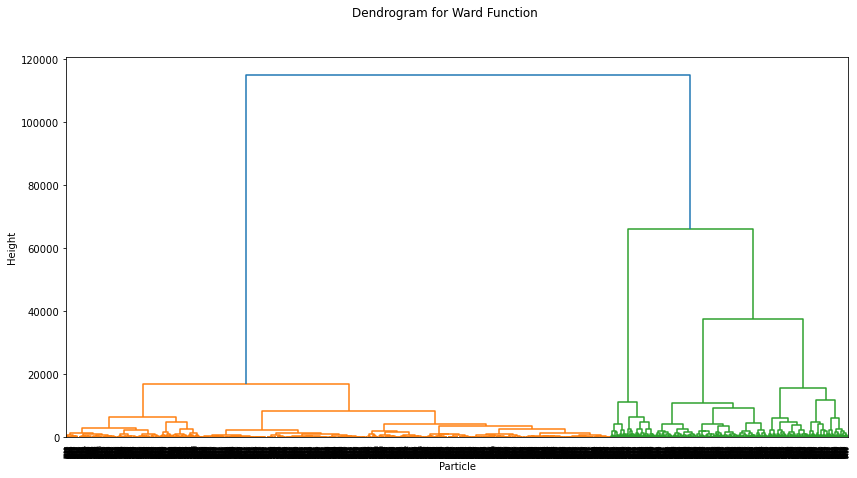

In [11]:
# Plot the dendrogram for the Ward proximity measure
index_names = list(df.index)

z = linkage(df,method='ward')
plt.figure(figsize = (14,7))
plt.suptitle('Dendrogram for Ward Function')
plt.xlabel('Particle')
plt.ylabel('Height')

dendrogramward = dendrogram(Z=z,labels=index_names,get_leaves=True)
plt.show()

In [12]:
# set the number of clusters and get the names
numclust = 6
fl = fcluster(z,numclust,criterion='maxclust')

# new dataframe
df_clst = pd.DataFrame()
df_clst['index']  = index_names
df_clst['clust_label']  = fl

# get the clusters from fcluster to choose centroids
centroids_idx = np.array([],dtype=int)
for i in range(6):
    # print the values in each group
    elements = df_clst[df_clst['clust_label']==i+1]['index'].tolist()  
    size = len(elements)    
    # get a random number from elements as a centroid
    centroids_idx = np.append(centroids_idx, random.choice(elements))
print(centroids_idx)

[1506 5297 3118 5285 1097  800]


### Find clusters based on k-means

In [13]:
# choose the centroids based on the smallest values from the particles
# we will choose the centroids at random from the 6 groups
# get the initial centroids
index_names = list(df.index)
c0 = df.iloc[index_names.index(centroids_idx[0])]
c1 = df.iloc[index_names.index(centroids_idx[1])]
c2 = df.iloc[index_names.index(centroids_idx[2])]
c3 = df.iloc[index_names.index(centroids_idx[3])]
c4 = df.iloc[index_names.index(centroids_idx[4])]
c5 = df.iloc[index_names.index(centroids_idx[5])]
# c6 = df.iloc[index_names.index(centroids_idx[6])]
# c7 = df.iloc[index_names.index(centroids_idx[7])]
# c8 = df.iloc[index_names.index(centroids_idx[8])]

centroids = np.array([c0,c1,c2,c3,c4,c5]) #c5,c6,c7,c8])
# centroids

In [14]:
# Compute the k-means clusters and show the listing of the States in each cluster
kmeans = KMeans(n_clusters=6,init=centroids,n_init=1,random_state=23).fit(df)
centroids = kmeans.cluster_centers_
assignment = kmeans.fit_predict(df,centroids)

# get the cluster for each state
zeroes=[x for x,y in enumerate(assignment) if y == 0]
ones=[x for x,y in enumerate(assignment) if y == 1]
twos=[x for x,y in enumerate(assignment) if y == 2]
threes=[x for x,y in enumerate(assignment) if y == 3]
fours=[x for x,y in enumerate(assignment) if y == 4]
fives=[x for x,y in enumerate(assignment) if y == 5]
# sixes=[x for x,y in enumerate(assignment) if y == 6]
# sevens=[x for x,y in enumerate(assignment) if y == 7]
# eights=[x for x,y in enumerate(assignment) if y == 8]

clusters = [zeroes,ones,twos,threes,fours,fives] #sevens,eights]
states = [[],[],[],[],[],[]] #[],[],[],[]]
num = 0
for clust in clusters:
    # cluster to append to is states[num]
    for idx in clust:
        state = index_names[idx]
        states[num].append(state)
    print('Cluster '+str(num)+':')
    print(len(states[num]))
    #for i in states[num]:
    #    print('     ',i)
    num += 1

Cluster 0:
1247
Cluster 1:
2537
Cluster 2:
299
Cluster 3:
665
Cluster 4:
458
Cluster 5:
252


In [15]:
# get the indices for each of the groups
group0 = states[0]
group1 = states[1]
group2 = states[2]
group3 = states[3]
group4 = states[4]
group5 = states[5]
# group6 = states[6]
# group7 = states[7]
# group8 = states[8]

groups = np.array([group0,group1,group2,group3,group4,group5],dtype=object)

### How good is the grouping?

#### Otherwise transfer neutral density to potential density using the plot in statistics/for_meeting_824/AABW_TS

In [16]:
dens = ds.variables["rho"].values[-1]
temp = ds.variables["temp"].values[-1]
salt = ds.variables["salt"].values[-1]
depth = ds.variables["depth"].values[-1]

In [17]:
# write a function to transfer neutral density to potential density based on the files
def find_nearest(array, value):
    if value == 0:
        idx = 0
    else:
        floor = math.floor(value)
        # see if we choose the 0.5 value or the 0 value
        if value>(floor+0.5):
            # choose 0.5 value
            searchval = floor+0.5
        else:
            searchval = floor
        idx = np.abs(array - searchval).argmin()
    return idx

def pot_to_neut(salt,temp):
    '''
    inputs: temp, salt arrays
    outputs: pot_rho: an array of the potential density values
    '''
    # write the arrays of values and their equivalents
    pot_grp = np.array([25  ,25.5,26  ,26.5,27  ,27.5,28])
    neut_grp = np.array([24.95,25.5,26.1,26.7,27.3,28  ,29])
    
    # create the potential density array in the same way as TS plots are created
    pot_dens = np.array([])
    for s,t in zip(salt,temp):
        dens=gsw.rho(s,t,0) -1000
        if dens>28:
            print(s,t)
        pot_dens = np.append(pot_dens,dens)
        
    # transfer this to the neutral density array based on the image in the file
    neut_dens = np.array([])
    for rho in pot_dens:
        # find the idx of the nearest lower in the neut_grp
        if not np.isnan(rho):
            idx = find_nearest(pot_grp,rho)

            # get the difference between rho and neut_grp[idx], what percent is this of idx and idx+1
            diff = rho - pot_grp[idx]
            perc = diff/(pot_grp[idx+1]-pot_grp[idx])

            # get the equivalent value in the other list and calculate neutral density
            add = perc*(neut_grp[idx+1]-neut_grp[idx])
            newval = neut_grp[idx]+add
        else:
            newval = np.nan
        neut_dens = np.append(neut_dens,newval)
        
    return neut_dens
enddens_allvals = pot_to_neut(salt,temp)

In [18]:
Freez_temp = gsw.CT_freezing(salt,0,0)
Freez_temp.shape

(5460,)

### Distributions of values in these nodes

In [19]:
'''
What are the parameters for each water mass

AABW: >28.27 neutral density, 1066.8+ ft depth, salinity 34.6-34.75,temperature <0
MCDW: T > Tf + 0.1, neutral density 28-28.27
ISW: T < Tf - 0.05
DSW: S > 34.5, Tf-0.5 to Tf+0.1, neutral density > 28.27
AASW: salinity < 34.5 and temperature greater than Tf

What are the arrays of ending values we have
temp
Freez_temp
salt
enddens_allvals
depth

'''

'\nWhat are the parameters for each water mass\n\nAABW: >28.27 neutral density, 1066.8+ ft depth, salinity 34.6-34.75,temperature <0\nMCDW: T > Tf + 0.1, neutral density 28-28.27\nISW: T < Tf - 0.05\nDSW: S > 34.5, Tf-0.5 to Tf+0.1, neutral density > 28.27\nAASW: salinity < 34.5 and temperature greater than Tf\n\nWhat are the arrays of ending values we have\ntemp\nFreez_temp\nsalt\nenddens_allvals\ndepth\n\n'

In [20]:
# coding 0 AABW, 1 MCDW, 2 ISW, 3 DSW, 4 AASW, 5 other, 6 HSSW
def wmt_chategorize(temp,Freez_temp,salt,enddens_allvals,depth):
    mass = np.array([],dtype=int)
    for t,tf,s,rho,d in zip(temp,Freez_temp,salt,enddens_allvals,depth):
        # aabw
        if d <= -1066.8 and rho >= 28.27 and s>=34.6 and s<=34.75 and t<=0:
            mass = np.append(mass,0)
        # dsw
        elif s>34.5 and t>=(tf-0.5) and t<=(tf+0.1) and rho>=28.27:
            mass = np.append(mass,3)
        # mcdw
        elif t>(tf+0.1) and rho>=28 and rho<=28.27:
            mass = np.append(mass,1)
        # hssw
        elif (t <= -1.7 and t >= -2) and (s >= 34.5) and (d>-1000):
            # add it to the list of indices of interest
            mass = np.append(mass,6)
        # aasw
        elif s<=34.7 and t>=tf:                                          # modified s
            mass = np.append(mass,4)
        # isw
        elif t<(tf-0):                                                    # modified tf
            mass = np.append(mass,2)
        # other
        else:
            if not np.isnan(s):
                print(t,tf,s,rho,d)
                mass = np.append(mass,5)
            else:
                mass = np.append(mass,np.nan)
    return(mass)
mass = wmt_chategorize(temp,Freez_temp,salt,enddens_allvals,depth)

In [21]:
# find the number of values in each group that match each of the water masses
# we have the arrays temp, freez_temp, salt, enddens_allvals, depth
lengths = np.array([])
AABW_percents = np.array([])
MCDW_percents = np.array([])
ISW_percents = np.array([])
DSW_percents = np.array([])
AASW_percents = np.array([])
HSSW_percents = np.array([])
other = np.array([])

for group in groups:
    # how many particles are in the group
    lengths = np.append(lengths,len(group))
    
    # get the individual quantities of each group from mass and do value counts
    thismass = mass[group]
    unique_elements, counts_elements = np.unique(thismass, return_counts=True)
    
    # see if any number is not in list and if not then add 0 to the end of the list
    for i in range(7):
        if not np.any(unique_elements == i):
            # append this number and zero to unique,counts
            unique_elements = np.append(unique_elements,i)
            counts_elements = np.append(counts_elements,0)
    
    for i in range(len(unique_elements)):
        if unique_elements[i] == 0:
            AABW_percents =np.append(AABW_percents,counts_elements[i])
        elif unique_elements[i] == 1:
            MCDW_percents =np.append(MCDW_percents,counts_elements[i])
        elif unique_elements[i] == 2:
            ISW_percents =np.append(ISW_percents,counts_elements[i])
        elif unique_elements[i] == 3:
            DSW_percents =np.append(DSW_percents,counts_elements[i])
        elif unique_elements[i] == 4:
            AASW_percents =np.append(AASW_percents,counts_elements[i])
        elif unique_elements[i] == 6:
            HSSW_percents =np.append(HSSW_percents,counts_elements[i])

In [22]:
wmt_df = pd.DataFrame()
wmt_df["# of particles"] = lengths
wmt_df["AABW"] = AABW_percents
wmt_df["MCDW"] = MCDW_percents
wmt_df["ISW"] = ISW_percents
wmt_df["DSW"] = DSW_percents
wmt_df["AASW"] = AASW_percents
wmt_df["HSSW"] = HSSW_percents
wmt_df

,# of particles,AABW,MCDW,ISW,DSW,AASW,HSSW
0,1247.0,0.0,418.0,214.0,239.0,346.0,30.0
1,2537.0,0.0,1638.0,55.0,67.0,750.0,27.0
2,299.0,299.0,0.0,0.0,0.0,0.0,0.0
3,665.0,429.0,8.0,26.0,0.0,202.0,0.0
4,458.0,453.0,0.0,2.0,0.0,3.0,0.0
5,252.0,252.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# we can try to separate these by running only with group3
# write group3 to a text file, then we can loop back to the beginning and rerun with only this group
with open("/scratch/project_2000789/muramarg/SOM/testing_clustering_methods/mixed_groupidxs.txt","w") as f:
    for i in group3:
        f.write(str(i))
        f.write("\n")
f.close()

### What are the distributions of variables in groups

In [ ]:
our_array = ds.variables["Xgrid"]

In [ ]:
# add the seasonality of the release times
# first we have to separate the points in df to those released in summer to those released in winter
# find the row indices of ds.variables['Xgrid'][:,aabw_idx] that correspond to summer/winter releases
# there are 35040 values in the first year, but the model did not run to completion, only to November of the second year
days = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
month_idx = (days*86400)/900
month_idx = np.cumsum(month_idx)
months = np.array(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
df_months = np.array([])
df_months_i = np.array([])

# make an array of the months in which particles are released
month_pts = np.array([])
for i in range(our_array.shape[1]):
    # get the first index of the column that is not a nan value
    thiscol = our_array[:,i]
    nonna = thiscol[~np.isnan(thiscol)]
    first_idx = len(thiscol)-len(nonna)
    
    # find the month index
    m = np.searchsorted(month_idx, first_idx,"left")
    df_months = np.append(df_months,months[m])
    df_months_i = np.append(df_months_i,m+1)

# df_months is now the months in which particles were released
# df_months_i is the number of the month; January=1

In [ ]:
# write release months to a text file
with open("/scratch/project_2000789/muramarg/SOM/testing_clustering_methods/release_months.txt","w") as f:
    for i in df_months_i:
        f.write(str(i))
        f.write("\n")
f.close()

In [ ]:
df

In [ ]:
# # Distribution of Various Quantities
fig = plt.figure(figsize = (15,8))
plt.suptitle("Distance Ratio Distributions")
fig.supxlabel('Net:Total Distance')
fig.supylabel('# of Instances')
i = 1

thisfig = df.columns[1]
for group in groups:
    ax = fig.add_subplot(2, 3, i)
    #plt.xlim(xmin=0, xmax = 2000)
    ax.hist(df[thisfig][group].values,alpha=0.7,edgecolor="black")
    #ax.hist(df_months_i[group],alpha=0.7,edgecolor="black")
    mystr = "Group" + str(i)
    #plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],labels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
    plt.xticks()
    plt.title(mystr)
    i  += 1
    
plt.savefig("/scratch/project_2000789/muramarg/SOM/testing_clustering_methods/meeting1_9/distributions/depth_vars/distratio.png", dpi=300)

### Where is the transition from DSW to AABW

In [ ]:
# import time

In [ ]:
# # code an entire array of values of the water mass type the same shape as ds.variables['x'].shape (65717,5460)
# wm_arr = np.empty((ds.variables['x'].shape))
# start_time = time.time()

# with open("/scratch/project_2000789/muramarg/SOM/testing_clustering_methods/wm_file.txt","w") as f:
#     #for i in range(5):
#     for i in range(wm_arr[:,0].shape[0]): 
#         if i%5000 == 0:
#             print(i,"in",(time.time()-start_time)/60)

#         # get the array values
#         dens = ds.variables["rho"].values[i]
#         temp = ds.variables["temp"].values[i]
#         salt = ds.variables["salt"].values[i]
#         depth = ds.variables["depth"].values[i]

#         # get the neutral density values
#         end_dens = pot_to_neut(salt,temp)

#         # characterize each value in the array
#         Freez_temp = gsw.CT_freezing(salt,0,0)
#         wm_mass = wmt_chategorize(temp,Freez_temp,salt,enddens_allvals,depth)

#         # reset the row in the wm_arr as this wm_mass
#         # wm_arr[i] = wm_mass
#         wm_mass = np.nan_to_num(wm_mass, nan=-1) 
#         f.write(" ".join(str(item) for item in wm_mass))
#         f.write("\n")
    
# f.close()

In [23]:
# test reading the file
with open("/scratch/project_2000789/muramarg/SOM/testing_clustering_methods/wm_alter.txt","r") as f:
    a = f.readlines()
    wm_arr = np.empty((ds.variables['x'].shape))
    for i in range(len(a)):
        b = a[i].split(" ")
        b = np.asarray(b)
        b[-1] = b[-1][:-1]
        b = b.astype(float)
        wm_arr[i] = b
f.close()

In [ ]:
# for each float, get the first and last locations of HSSW, DSW, and AABW
firstlast_arr = np.empty((5,5460))
row1 = np.array([])
row2 = np.array([])
row3 = np.array([])
row4 = np.array([])
row5 = np.array([])
row6 = np.array([])

for i in range(5460):
    thiscol = wm_arr[:,i]
    flipcol = np.flip(thiscol)
    # hssw is 6
    idx = np.argmax(thiscol==6)
    if idx != 0:
        row1 = np.append(row1,idx)
    else:
        row1 = np.append(row1,np.nan)
    idx = 65717-np.argmax(thiscol==6)-1
    if idx != 65716:
        row2 = np.append(row2,idx)
    else:
        row2 = np.append(row2,np.nan)
    
    # dsw is 3
    idx = np.argmax(thiscol==3)
    if idx != 0:
        row3 = np.append(row3,idx)
    else:
        row3 = np.append(row3,np.nan)
    idx = 65717-np.argmax(thiscol==3)-1
    if idx != 65716:
        row4 = np.append(row4,idx)
    else:
        row4 = np.append(row4,np.nan)
    
    # aabw is 0
    idx = np.argmax(thiscol==0)
    if idx != 0:
        row5 = np.append(row5,idx)
    else:
        row5 = np.append(row5,np.nan)
        
# find these x and y indexes in the ds.variables['x'].values array
firstlast_arr[0] = row1
firstlast_arr[1] = row2
firstlast_arr[2] = row3
firstlast_arr[3] = row4
firstlast_arr[4] = row5

In [24]:
x = ds.variables['Xgrid'].values
y = ds.variables['Ygrid'].values

In [ ]:
# get the location indices for plotting
x_arr = np.empty((5,5460))
y_arr = np.empty((5,5460))

for i in range(len(firstlast_arr)):
    for j in range(len(firstlast_arr[i])):
        xcol = x[:,j]
        ycol = y[:,j]
        # get the index that we found in the previous step
        if not np.isnan(firstlast_arr[i][j]):
            xi = xcol[int(firstlast_arr[i][j])]
            yi = ycol[int(firstlast_arr[i][j])]
        else:
            xi = np.nan
            yi = np.nan
        x_arr[i][j] = xi
        y_arr[i][j] = yi

In [25]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(20,14))
fig.tight_layout(pad=10)
ax = fig.add_subplot(2, 3, 1,projection=proj)
plt.rcParams.update({'font.size': 12})
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 1")
# plot the points as different colors
plt.scatter(x_arr[0:2][:,group0],y_arr[0:2][:,group0],marker='.',s=0.5,color='tab:pink')
plt.scatter(x_arr[2:4][:,group0],y_arr[2:4][:,group0],marker='.',s=0.5,color='tab:red')
plt.scatter(x_arr[4:][:,group0],y_arr[4:][:,group0],marker='.',s=0.5,color='tab:orange')

ax = fig.add_subplot(2, 3, 2,projection=proj)
plt.rcParams.update({'font.size': 12})
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 2")
# plot the points as different colors
plt.scatter(x_arr[0:2][:,group1],y_arr[0:2][:,group1],marker='.',s=0.5,color='tab:pink')
plt.scatter(x_arr[2:4][:,group1],y_arr[2:4][:,group1],marker='.',s=0.5,color='tab:red')
plt.scatter(x_arr[4:][:,group1],y_arr[4:][:,group1],marker='.',s=0.5,color='tab:orange')

ax = fig.add_subplot(2, 3, 3,projection=proj)
plt.rcParams.update({'font.size': 12})
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 3")
# plot the points as different colors
plt.scatter(x_arr[0:2][:,group2],y_arr[0:2][:,group2],marker='.',s=0.5,color='tab:pink')
plt.scatter(x_arr[2:4][:,group2],y_arr[2:4][:,group2],marker='.',s=0.5,color='tab:red')
plt.scatter(x_arr[4:][:,group2],y_arr[4:][:,group2],marker='.',s=0.5,color='tab:orange')

ax = fig.add_subplot(2, 3, 4,projection=proj)
plt.rcParams.update({'font.size': 12})
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 4")
# plot the points as different colors
plt.scatter(x_arr[0:2][:,group3],y_arr[0:2][:,group3],marker='.',s=0.5,color='tab:pink')
plt.scatter(x_arr[2:4][:,group3],y_arr[2:4][:,group3],marker='.',s=0.5,color='tab:red')
plt.scatter(x_arr[4:][:,group3],y_arr[4:][:,group3],marker='.',s=0.5,color='tab:orange')

ax = fig.add_subplot(2, 3, 5,projection=proj)
plt.rcParams.update({'font.size': 12})
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 5")
# plot the points as different colors
plt.scatter(x_arr[0:2][:,group4],y_arr[0:2][:,group4],marker='.',s=0.5,color='tab:pink')
plt.scatter(x_arr[2:4][:,group4],y_arr[2:4][:,group4],marker='.',s=0.5,color='tab:red')
plt.scatter(x_arr[4:][:,group4],y_arr[4:][:,group4],marker='.',s=0.5,color='tab:orange')

ax = fig.add_subplot(2, 3, 6,projection=proj)
plt.rcParams.update({'font.size': 12})
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 6")
# plot the points as different colors
plt.scatter(x_arr[0:2][:,group5],y_arr[0:2][:,group5],marker='.',s=0.5,color='tab:pink')
plt.scatter(x_arr[2:4][:,group5],y_arr[2:4][:,group5],marker='.',s=0.5,color='tab:red')
plt.scatter(x_arr[4:][:,group5],y_arr[4:][:,group5],marker='.',s=0.5,color='tab:orange')

plt.savefig("/scratch/project_2000789/muramarg/SOM/testing_clustering_methods/meeting1_9/transition_points.png", dpi=300)

In [ ]:
# # edit the cmap to RGB values
# wm_cmap = np.empty((ds.variables['x'].shape),dtype=str)

# # set values based on colors
# for i in range(len(wm_arr)):
#     for j in range(len(wm_arr[i])):
#         if wm_arr[i][j] == -1:
#             wm_cmap[i][j] = np.nan
#         if wm_arr[i][j] == 0:
#             wm_cmap[i][j] = "#EF476F"
#         if wm_arr[i][j] == 1:
#             wm_cmap[i][j] = "#FFD166"
#         if wm_arr[i][j] == 2:
#             wm_cmap[i][j] = "#06D6A0"
#         if wm_arr[i][j] == 3:
#             wm_cmap[i][j] = "#118AB2"
#         if wm_arr[i][j] == 4:
#             wm_cmap[i][j] = "#073B4C"
#         if wm_arr[i][j] == 5:
#             wm_cmap[i][j] = "#23cc4a"
#         if wm_arr[i][j] == 6:
#             wm_cmap[i][j] = "#f08826"

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmap = ListedColormap(["tab:blue", "tab:orange", "tab:green", "tab:red","tab:purple","tab:brown"])
cmap2 = ListedColormap(["tab:orange", "tab:green", "tab:red","tab:purple","tab:brown"])

In [ ]:
# plot all the groups colored by the water mass grid
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(8,10))
# fig.tight_layout(pad=10)
ax = fig.add_subplot(1, 1, 1,projection=proj)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("WMT of All Points")
# plot the points as different colors
plt.scatter(x,y,marker='.',s=0.1,c=wm_arr,cmap=cmap)
labels=["AABW", "MCDW","ISW","DSW","AASW","HSSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(labels)

plt.savefig("/scratch/project_2000789/muramarg/SOM/testing_clustering_methods/meeting1_9/wmt_colored2.png", dpi=300)

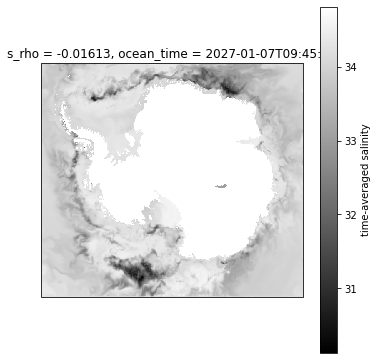

In [27]:
from matplotlib import colorbar, colors

proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(20,14))
fig.tight_layout(pad=10)
ax = fig.add_subplot(2, 3, 1,projection=proj)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot(cmap=plt.get_cmap('gray'))
# cbar = colorbar.ColorbarBase(ax, cmap=plt.get_cmap('Greys'))
# plt.colorbar(cb, cmap=mpl.colormaps["Greys"])
# mpl.colormaps["Greys"]

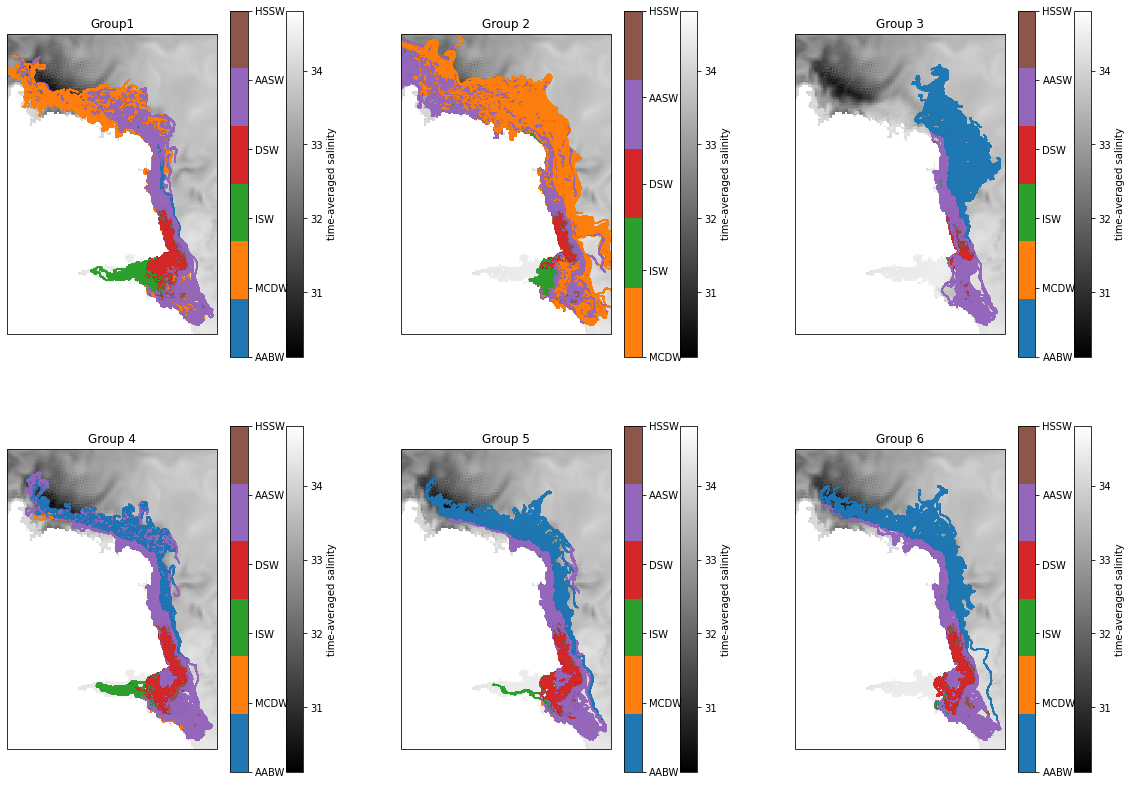

In [28]:
# plot all the groups colored by the water mass grid
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(20,14))
fig.tight_layout(pad=10)
ax = fig.add_subplot(2, 3, 1,projection=proj)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group1")
# plot the points as different colors
plt.scatter(x[:,group0],y[:,group0],marker='.',s=0.1,c=wm_arr[:,group0],cmap=cmap)
labels=["AABW","MCDW","ISW","DSW","AASW","HSSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(labels)

ax = fig.add_subplot(2, 3, 2,projection=proj)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 2")
# plot the points as different colors
plt.scatter(x[:,group1],y[:,group1],marker='.',s=0.1,c=wm_arr[:,group1],cmap=cmap2)
labels=["MCDW","ISW","DSW","AASW","HSSW"]
cbar = plt.colorbar(ticks=[1,2,3,4,5])
cbar.ax.set_yticklabels(labels)

ax = fig.add_subplot(2, 3, 3,projection=proj)
ds1.salt.isel(s_rho=-1, ocean_time=1).plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 3")
# plot the points as different colors
plt.scatter(x[:,group2],y[:,group2],marker='.',s=0.1,c=wm_arr[:,group2],cmap=cmap)
labels=["AABW", "MCDW","ISW","DSW","AASW","HSSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(labels)

ax = fig.add_subplot(2, 3, 4,projection=proj)
# plt.rcParams.update({'font.size': 12})
ds1.salt.isel(s_rho=-1, ocean_time=1).plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 4")
# plot the points as different colors
plt.scatter(x[:,group3],y[:,group3],marker='.',s=0.1,c=wm_arr[:,group3],cmap=cmap)
labels=["AABW", "MCDW","ISW","DSW","AASW","HSSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(labels)

ax = fig.add_subplot(2, 3, 5,projection=proj)
# plt.rcParams.update({'font.size': 12})
ds1.salt.isel(s_rho=-1, ocean_time=1).plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 5")
# plot the points as different colors
plt.scatter(x[:,group4],y[:,group4],marker='.',s=0.1,c=wm_arr[:,group4],cmap=cmap)
labels=["AABW", "MCDW","ISW","DSW","AASW","HSSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(labels)

ax = fig.add_subplot(2, 3, 6,projection=proj)
# plt.rcParams.update({'font.size': 12})
ds1.salt.isel(s_rho=-1, ocean_time=1).plot(cmap=plt.get_cmap('gray'))
plt.xlim([420,560])
plt.ylim([330,530])
plt.title("Group 6")
# plot the points as different colors
plt.scatter(x[:,group5],y[:,group5],marker='.',s=0.1,c=wm_arr[:,group5],cmap=cmap)
labels=["AABW", "MCDW","ISW","DSW","AASW","HSSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(labels)

plt.savefig("/scratch/project_2000789/muramarg/SOM/testing_clustering_methods/meeting1_9/wmt_colored_groupbydepth2.png", dpi=300)

### Why aren't Groups 1 and 2 becoming bottom water?

### If we rerun the model with specific groups, which would we rerun with

In [ ]:
# group 1 and group 2

### Select the points from these that may be AABW, recreate groups

In [ ]:
# select the groups based on the results of the previous section
aabw_idx = np.concatenate((group0,group1,group5,group8))
aabw_idx.shape

In [ ]:
# # make new groups based on those that end as aabw
# aabw_temp_last = ds.variables["temp"].values[:,aabw_idx][-1]
# aabw_dep_last = ds.variables["depth"].values[:,aabw_idx][-1]
# dens_last = pot_dens[:,aabw_idx][-1]

# df_aa = pd.DataFrame()
# df_aa["temp"] = aabw_temp_last
# df_aa["depth"] = aabw_dep_last
# df_aa["density"] = dens_last
# df_aa['idx'] = aabw_idx
# # df_aa

In [ ]:
# # select groups based on conditions
# df_aa = df_aa[df_aa['temp'] <= -0]
# df_aa = df_aa[df_aa['depth'] <= -1066.8] # meters
# df_aa = df_aa[df_aa['density'] > 28.27]
# df_aa

In [ ]:
# # idx column will be used to retrain dendrogram and kmeans
# df_X = df.iloc[df_aa['idx']]
# index_names = list(df_X.index)

### Write the output cells to a file to visualize in other document

In [ ]:
# write these indexes to a text file
with open('recreate_groups.txt', 'w') as f:
    for idx in aabw_idx:
        f.write(str(idx))
        f.write('\n')